In [1]:
import sys
import os
sys.path.insert(0, os.getcwd()+'/src/')
sys.path.insert(0, '/home/mcarenso/code/stage-2023-multiscale-extremes/scripts/src/')
from myImports import *
%matplotlib inline
%load_ext autoreload

## Load Rain Extremes object and collect data

In [4]:
from ProcessingMCS import ProcessMCS
Re = ProcessMCS()

entire map 8480824.673795126
tranche de latitude :  424041.2336897563
tranche de longitude :  265025.7710560977
s 13251.288552804885
DYAMOND 130E_165E_0N_20N SAM
<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*


In [5]:
# Re.ds.to_netcdf(Re.path_safeguard+'all.nc', format='NETCDF4', mode='w')
for var in Re.variables:
    for diag in Re.diags:
        Re.save(var, diag, day0 = 0, dayf = 14)
Re.saveMaxPrecip(0, 14)
Re.saveMeanPrecip(0, 14)

PW_ac not saved, saving...
PW_c not saved, saving...
PW_MCS not saved, saving...
WindConv_ac not saved, saving...
WindConv_c not saved, saving...
WindConv_MCS not saved, saving...
QVsat_ac not saved, saving...
QVsat_c not saved, saving...
QVsat_MCS not saved, saving...
Max prec not saved, saving...
Mean prec not saved, saving...


In [8]:
Prec_max = Re.ds['max_prec'].values.flatten()
Prec_mean = Re.ds['mean_prec'].values.flatten()

In [9]:
#Compute Distribution for Prec_max

dist_Prec_max = cs.Distribution(name="Dyamond Max Precipitation", bintype = "invlogQ", nd = 4, fill_last_decade=True)
dist_Prec_max.computeDistribution(sample = Prec_max)
dist_Prec_max.storeSamplePoints(sample = Prec_max)

dist_Prec_mean = cs.Distribution(name="Dyamond Mean Precipitation", bintype = "invlogQ", nd = 4, fill_last_decade=True)
dist_Prec_mean.computeDistribution(sample = Prec_mean)
dist_Prec_mean.storeSamplePoints(sample = Prec_mean)

/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


## Mean Max Density 



In [10]:
jd_Mean_Max_IL = cs.JointDistribution(name='Mean vs Max',distribution1=dist_Prec_mean, distribution2=dist_Prec_max)
P_Cap, Norm, Ni, Nj, Ntot= jd_Mean_Max_IL.computeNormalizedDensity(Prec_mean, Prec_max, data = None)

/home/mcarenso/code/conditional-stats/src/conditionalstats.py:1132: RuntimeWarning: invalid value encountered in true_divide
  else : return self.density/Norm/Ntot, 1/Norm, N1, N2, Ntot
/home/mcarenso/code/conditional-stats/src/conditionalstats.py:1132: RuntimeWarning: divide by zero encountered in true_divide
  else : return self.density/Norm/Ntot, 1/Norm, N1, N2, Ntot


## Plot variables

In [11]:
# Mean_Max_Jd_PW_MCS= jd_Mean_Max_IL.computeNormalizedDensity(Prec_mean, Prec_max, data = Re.ds['PW_c'].values.flatten())
# fig,ax = plt.subplots(figsize=(5,4))
# ax_show = ax.twinx().twiny()
# ax = setFrameIL(ax, dist_Prec_mean.ranks, dist_Prec_max.ranks, xlabel = "Mean Precip", ylabel = "Max Precip") ## the given ax object must not be ax_show. 

# Z = Mean_Max_Jd_PW_MCS.T
# h = showJointHistogram(ax_show, Z, scale = 'linear',  vmin = None, vmax = None, cmap = 'Blues')
# plt.colorbar(h)
# plt.title("Precipitable Water in MCS")

/home/mcarenso/code/conditional-stats/src/conditionalstats.py:1126: RuntimeWarning: Mean of empty slice
  data_over_density[i1, i2] = np.nanmean(data[data_idx])


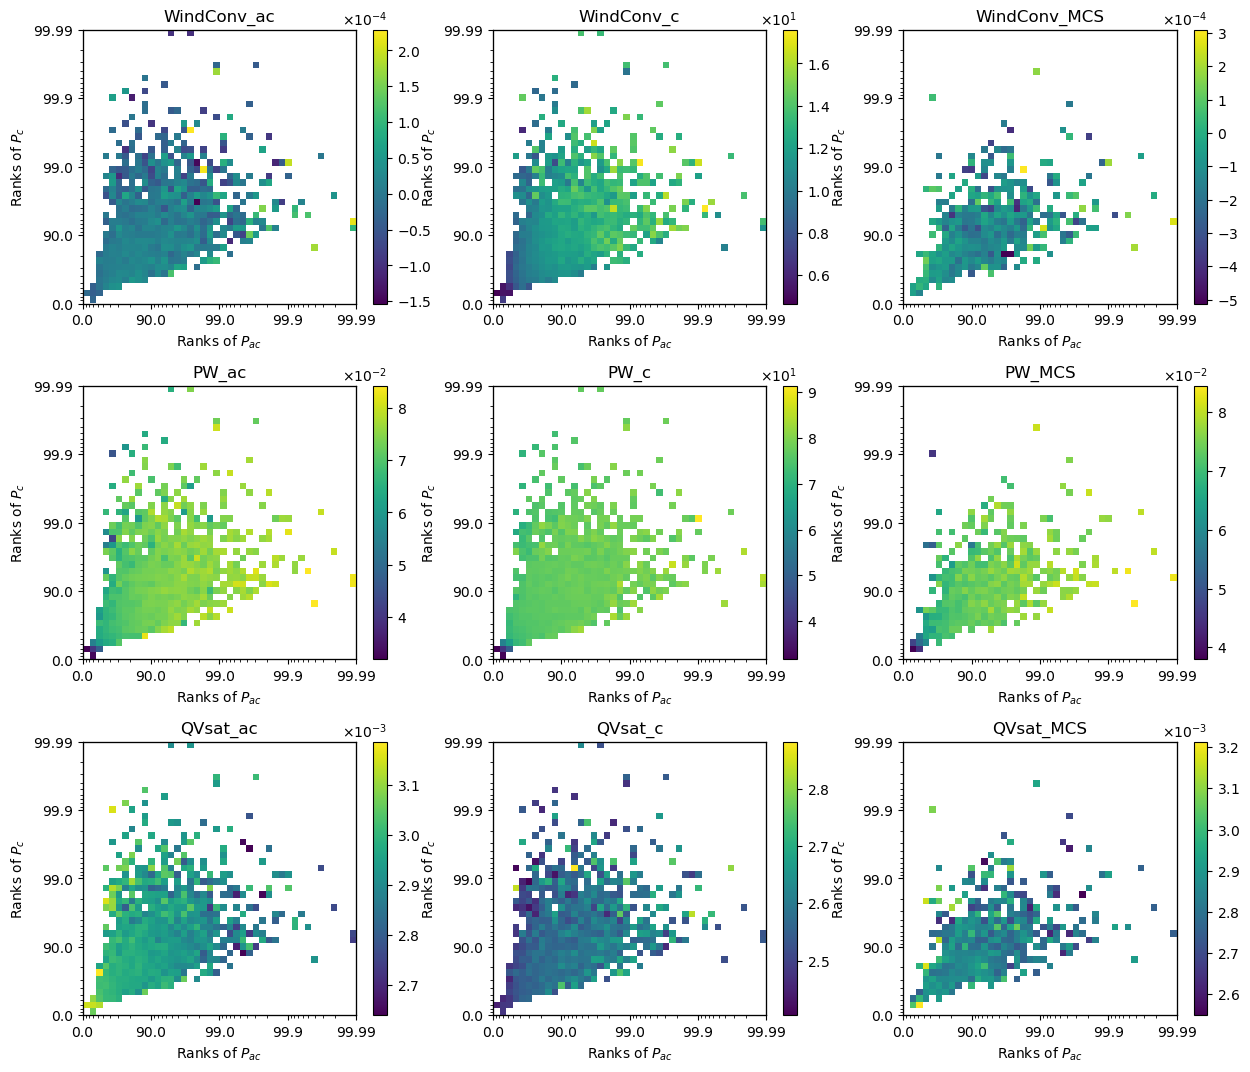

In [12]:
import matplotlib.ticker as ticker

# Assuming you have multiple keys in a list called 'all_keys'
all_keys = ['WindConv_ac', 'WindConv_c', 'WindConv_MCS', 'PW_ac', 'PW_c', 'PW_MCS',
            'QVsat_ac', 'QVsat_c', 'QVsat_MCS']
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12.8))
plt.subplots_adjust(hspace=0.3)  # Adjust vertical space between subplots

for idx, key in enumerate(all_keys):
    row = idx // 3  
    col = idx % 3  

    Mean_Max_Jd_key = jd_Mean_Max_IL.computeNormalizedDensity(Prec_mean, Prec_max, data=Re.ds[key].values.flatten())
    ax = axs[row, col]
    ax_show = ax.twinx().twiny()  # Create twin axes for each main axis.

    ax = setFrameIL(ax, dist_Prec_mean.ranks, dist_Prec_max.ranks, xlabel="Ranks of $P_{ac}$", ylabel="Ranks of $P_{c}$")
    Z = Mean_Max_Jd_key.T
    h = showJointHistogram(ax_show, Z, scale='linear', vmin=None, vmax=None, cmap='viridis')
    fmt = ticker.ScalarFormatter(useMathText=True)
    fmt.set_powerlimits((0, 0))
    cbar = plt.colorbar(h, ax=ax, format=fmt)  # Setting the format to display 2 decimal places.
    ax.set_title(key)

# plt.suptitle("Environmental data sampled by different diagnosis over $D(P_c, P_{ac}$)", fontsize=16)
plt.show()

## Map

In [13]:
# Re.label_files = np.sort(os.listdir(Re.path_label))
# Re.df = Re.loadRelTable()

In [14]:
print(Re.label_files[-1])
## get row 45 of Re.df
Re.df.iloc[-2]

ImageSegTOOCAN_20160910-01.nc


Unnamed: 0.5                                                 1313
Unnamed: 0.4                                               1313.0
Unnamed: 0.3                                               1313.0
Unnamed: 0.2                                                 1313
img_seg_path    data/fiolleau/DYAMOND/TOOCAN/TOOCAN_v2.07/GLOB...
str_code                                           2016-9-9-23-30
Unnamed: 0.1                                                 1918
Unnamed: 0                                                   1918
year                                                         2016
month                                                           9
day                                                             9
hour                                                           23
minute                                                         30
path_dyamond        DYAMOND_9216x4608x74_7.5s_4km_4608_0000460560
UTC                                                      17053.47
Name: 656,

In [15]:
timelag = 0
my_path = '/homedata/mcarenso/figures/rain_out_of_MCS/DYAMOND/'+'timelag'+str(timelag)+'/'


/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/xarray/conventions.py:551: SerializationWarning: variable 'MCS_label' has multiple fill values {-999.0, -998.0}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


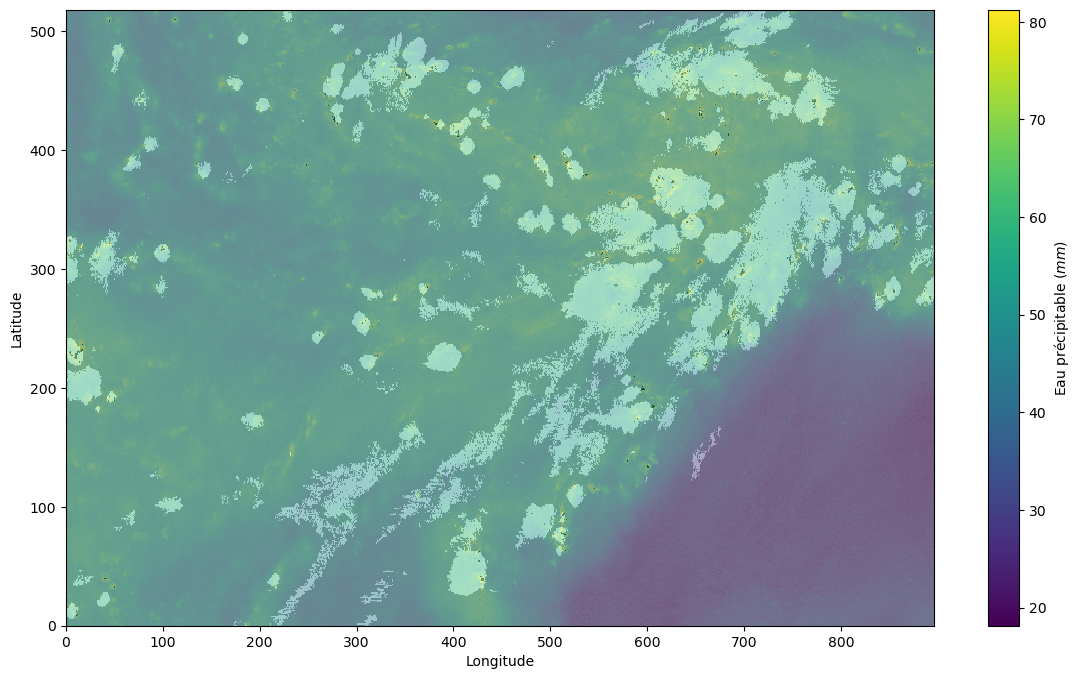

In [19]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 8))

for i_t in np.arange(500, 501):
    # Assuming the following functions for loading the data
    Z = Re.load_PW(i_t)
    Precip = Re.loadPrec(i_t)
    Grey = Re.loadLabels(i_t+timelag)

    plt.pcolormesh(Z, cmap='viridis', alpha=1, figure=fig)
    plt.colorbar(label='Eau précipitable $(mm)$')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    Grey = np.where(np.isnan(Grey), 1, 0)
    plt.pcolormesh(Grey, cmap='Greys', alpha=0.33, figure=fig, label='MCS')

    threshold_value = np.percentile(Precip, 99.9)
    precip_dots = np.where(Precip > threshold_value, 1, 0)
    plt.pcolormesh(precip_dots, cmap='Greys', alpha=0.33, figure=fig, label='P_99')

    # Save the plot as a PNG file
    output_path = my_path + str(i_t) + '.png'
    # plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()


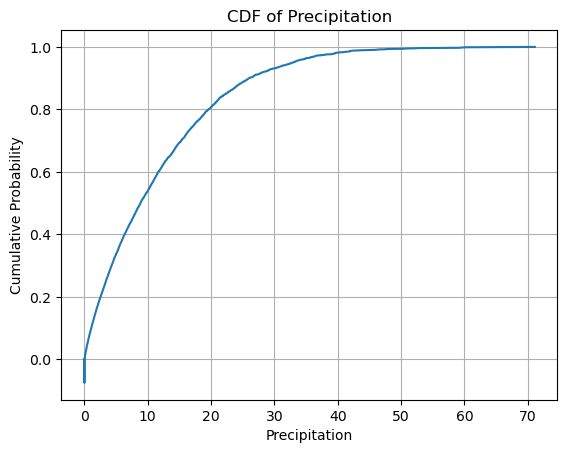

In [ ]:
Precip = Precip.values.flatten()

# Assuming `Precip` is already defined and contains the precipitation data

# Calculate the CDF
sorted_precip = np.sort(Precip)
cumulative_prob = np.cumsum(sorted_precip) / np.sum(sorted_precip)

# Plot the CDF
plt.plot(sorted_precip, cumulative_prob)
plt.xlabel('Precipitation')
plt.ylabel('Cumulative Probability')
plt.title('CDF of Precipitation')
plt.grid(True)
plt.show()


In [ ]:
stringSST = "300"

sam_file_seg='/bdd/MT_WORKSPACE/MCS/RCE/SAM/TOOCAN/TOOCAN_v2023_05/Dspread0K/irtb/TOOCAN_2.07_SAM_large300_2D_irtb.nc'
sam_file_tracking='/bdd/MT_WORKSPACE/MCS/RCE/SAM/TOOCAN/TOOCAN_v2023_05/Dspread0K/irtb/FileTracking/TOOCAN-SAM_large300_2D_irtb.dat.gz'
sam_sim_path = '/bdd/MT_WORKSPACE/REMY/RCEMIP/SAM/300K/rcemip_large_2048x128x74_3km_12s_300K_64.2Dcom_1.nc'
sam_output_path = "/homedata/mcarenso/Stage2023/SAM/"+stringSST+"K/"

mesonh_file_seg='/bdd/MT_WORKSPACE/MCS/RCE/MESONH/TOOCAN/TOOCAN_v2023_05/Dspread0K/irtb/TOOCAN_2.07_MESONH_large300_2D_irtb.nc'
mesonh_file_tracking='/bdd/MT_WORKSPACE/MCS/RCE/MESONH/TOOCAN/TOOCAN_v2023_05/Dspread0K/irtb/FileTracking/TOOCAN-MESONH_large300_2D_irtb.dat.gz'
mesonh_sim_path = '/bdd/MT_WORKSPACE/MCS/RCE/MESONH/INPUTS/v2023_05/MESONH_RCE_large300_2D_pr.nc'
mesonh_olr_path = '/bdd/MT_WORKSPACE/MCS/RCE/MESONH/INPUTS/v2023_05/MESONH_RCE_large300_2D_olr.nc'
mesonh_output_path = "/homedata/mcarenso/Stage2023/MESONH/"+stringSST+"K/"

icon_file_seg = '/bdd/MT_WORKSPACE/MCS/RCE/ICON/TOOCAN/TOOCAN_v2023_05/Dspread0K/irtb/TOOCAN_2.07_ICON_large300_2D_irtb.nc'
icon_file_tracking = '/bdd/MT_WORKSPACE/MCS/RCE/ICON/TOOCAN/TOOCAN_v2023_05/Dspread0K/irtb/FileTracking/TOOCAN-ICON_large300_2D_irtb.dat.gz' #'/bdd/MT_WORKSPACE/MCS/RCE/ICON/TOOCAN/TOOCAN_v2023_05/Dspread0K/irtb/FileTracking/TOOCAN-ICON_large300_2D_irtb.dat.gz' 
icon_sim_path = '/bdd/MT_WORKSPACE/MCS/RCE/ICON/INPUTS/v2023_05/ICON_RCE_large300_2D_pr.nc'
icon_irtb_path = '/bdd/MT_WORKSPACE/MCS/RCE/ICON/INPUTS/v2023_05/ICON_RCE_large300_2D_irtb.nc'
icon_output_path = "/homedata/mcarenso/Stage2023/ICON/"+stringSST+"K_no_filter/"

In [ ]:
ds = xr.open_dataset(sam_sim_path, decode_times=False)
ds

<xarray.Dataset>
Dimensions:   (x: 2048, y: 128, time: 1000)
Coordinates:
  * x         (x) float32 0.0 3e+03 6e+03 ... 6.135e+06 6.138e+06 6.141e+06
  * y         (y) float32 0.0 3e+03 6e+03 9e+03 ... 3.75e+05 3.78e+05 3.81e+05
  * time      (time) float32 75.0 75.02 75.04 75.06 ... 95.75 95.77 95.79 95.81
Data variables: (12/69)
    Prec      (time, y, x) float32 ...
    SHF       (time, y, x) float32 ...
    LHF       (time, y, x) float32 ...
    LWNS      (time, y, x) float32 ...
    LWNSC     (time, y, x) float32 ...
    LWNT      (time, y, x) float32 ...
    ...        ...
    rsuscs    (time, y, x) float32 ...
    hadvfmse  (time, y, x) float32 ...
    vadvfmse  (time, y, x) float32 ...
    advfmse   (time, y, x) float32 ...
    VIH_inst  (time, y, x) float32 ...
    var_h_in  (time, y, x) float32 ...

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

i_t = 450

# for each model, load the data
sam = xr.open_dataset(sam_sim_path, decode_times=False)["PW"]
sam = sam.values[i_t,:,:]

Precip_sam = xr.open_dataset(sam_sim_path, decode_times=False)["Prec"]
Precip_sam = Precip_sam.values[i_t,:,:]

Grey_sam = xr.open_dataarray(sam_file_seg, decode_times=False)
Grey_sam = Grey_sam.values[i_t,:,:]

mesonh = xr.open_dataset(mesonh_olr_path, decode_times=False)["olr"]
mesonh = mesonh.values[i_t,:,:]

Precip_mesonh = xr.open_dataset(mesonh_sim_path, decode_times=False)["pr"]
Precip_mesonh = Precip_mesonh.values[i_t,:,:]

Grey_mesonh = xr.open_dataarray(mesonh_file_seg, decode_times=False)
Grey_mesonh = Grey_mesonh.values[i_t,:,:]

icon = xr.open_dataset(icon_irtb_path, decode_times=False)["irtb"]
icon = icon.values[i_t,:,:]

Precip_icon = xr.open_dataset(icon_sim_path, decode_times=False)["pr"]
Precip_icon = Precip_icon.values[i_t,:,:]

Grey_icon = xr.open_dataarray(icon_file_seg, decode_times=False)
Grey_icon = Grey_icon.values[i_t,:,:]

0
<class 'numpy.ndarray'>
(128, 2048)
(128, 2048)
1
<class 'numpy.ndarray'>
(128, 2000)
(128, 2000)
2
<class 'numpy.ndarray'>
(128, 2000)
(128, 2000)


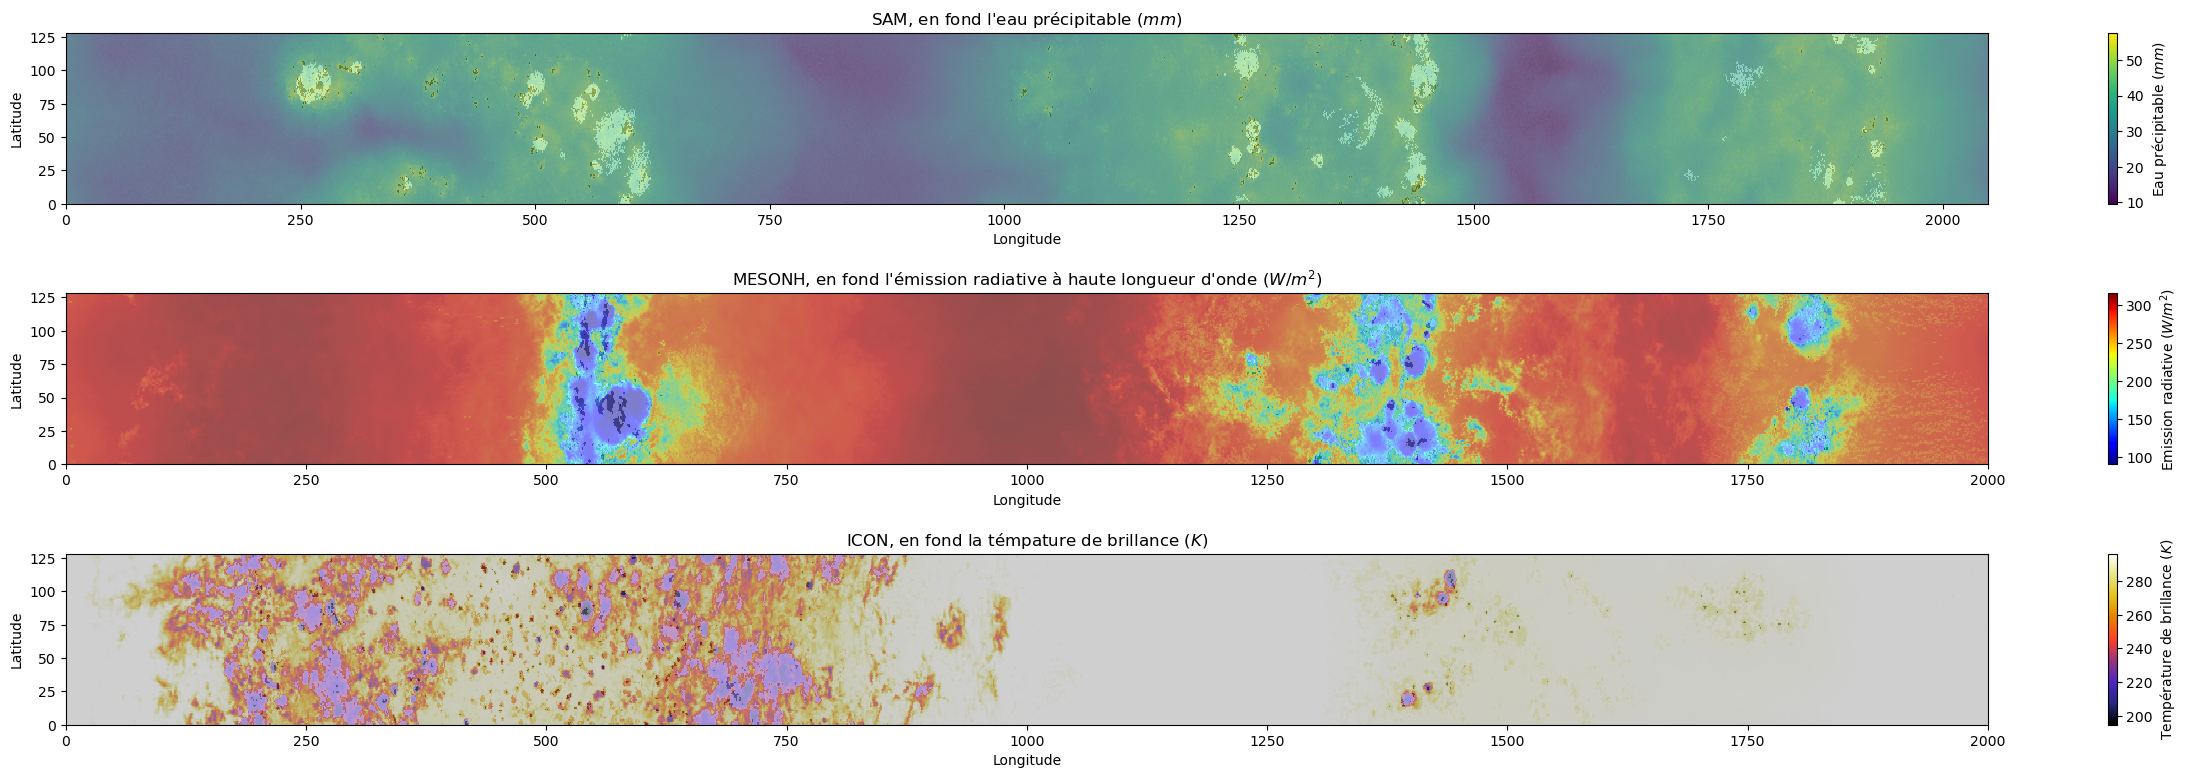

In [ ]:
fig, axs= plt.subplots(3, 1, figsize=(25, 8))
Greys = [Grey_sam, Grey_mesonh, Grey_icon]
Precips = [Precip_sam, Precip_mesonh, Precip_icon]
data = [sam, mesonh, icon]
data_label = ['pw', 'olr', 'irtb']
cmaps = ['viridis', 'jet', 'CMRmap']
labels = ['Eau précipitable $(mm)$', 'Emission radiative $(W/m^2)$', 'Température de brillance $(K)$']
titles = ['SAM, en fond l\'eau précipitable $(mm)$', 'MESONH, en fond l\'émission radiative à haute longueur d\'onde $(W/m^2)$', 'ICON, en fond la témpature de brillance $(K)$']
for i, ax in enumerate(axs):
    print(i)
    Grey, Precip, Z, cmap = Greys[i], Precips[i], data[i], cmaps[i]
    

    ax.pcolormesh(Z, cmap=cmap, alpha=0.9)
    fig.colorbar(cm.ScalarMappable(norm=Normalize(np.min(Z), np.max(Z)), cmap=cmap), ax=ax, label=labels[i])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(titles[i])
    
    
    Grey = np.where(np.isnan(Grey), 1, 0)
    ax.pcolormesh(Grey, cmap='Greys', alpha=0.25)
    print(type(Precip))
    print(np.shape(Precip))
    threshold_value = np.percentile(Precip, 99.5)
    precip_dots = np.where(Precip > threshold_value, 1, 0)
    print(precip_dots.shape)
    ax.pcolormesh(precip_dots, cmap='Greys', alpha=0.25)

fig.tight_layout(pad=1.5)
plt.show()

## density plot

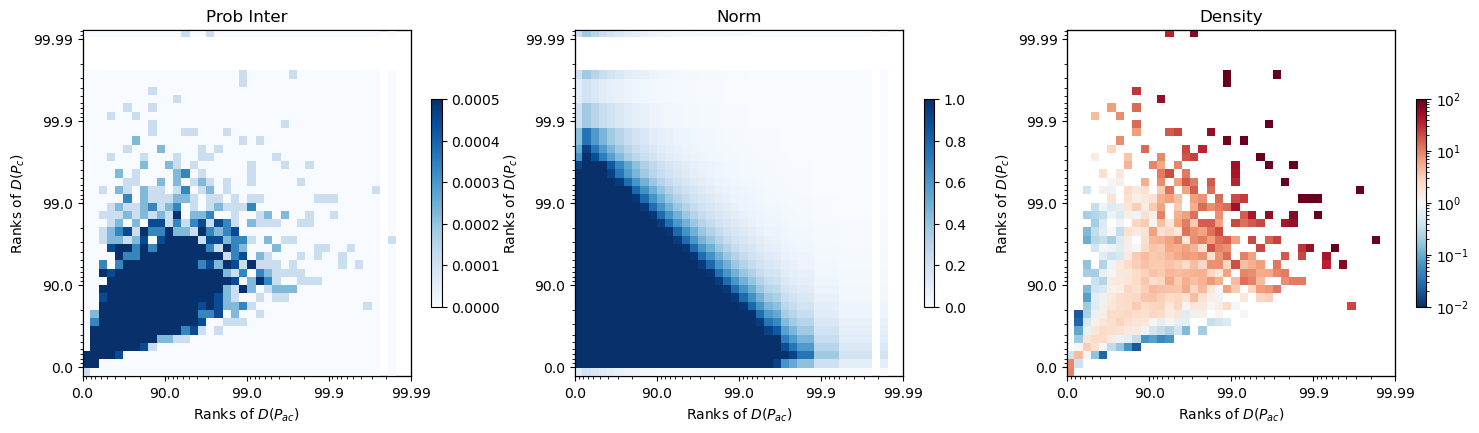

In [ ]:
fig,axs = plt.subplots(ncols = 3, nrows =1, figsize=(18,4.5))
vmins = [0,0,1e-2]
vmaxs = [0.0005,1,1e2]
scales = ['linear','linear','log']
cmaps = ['Blues','Blues','RdBu_r']
legends = ['Prob Inter', 'Norm', 'Density']
i=0
for Z, ax, vmin, vmax, scale, cmap, legend in zip([P_Cap, Norm, jd_Mean_Max_IL.density], axs, vmins, vmaxs, scales, cmaps, legends) : 
    ax_show = ax.twinx().twiny()
    ax = setFrameIL(ax, dist_Prec_mean.ranks, dist_Prec_max.ranks, xlabel = "Ranks of $D(P_{ac})$", ylabel = "Ranks of $D(P_c)$") ## the given ax object must not be ax_show. 

    h = showJointHistogram(ax_show, Z.T, scale = scale, vmin = vmin,vmax =vmax, cmap = cmap)
    
    cbar = fig.colorbar(h, ax=ax, shrink=0.6)  # Adjust the "shrink" value as needed
    ax.set_title(legend)

plt.show()


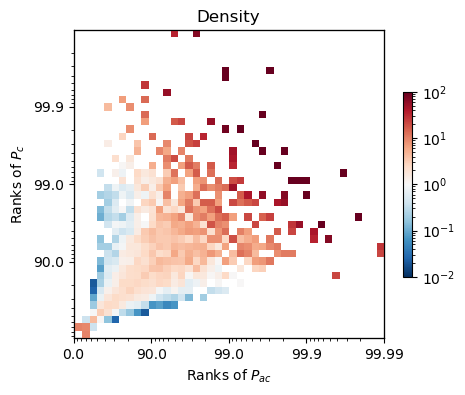

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))
vmin = 1e-2
vmax = 1e2
scale = 'log'
cmap = 'RdBu_r'
legend = 'Density'

ax_show = ax.twinx().twiny()
ax = setFrameIL(ax, dist_Prec_mean.ranks, dist_Prec_max.ranks, xlabel = "Ranks of $P_{ac}$", ylabel = "Ranks of $P_c$") ## the given ax object must not be ax_show. 

h = showJointHistogram(ax_show, Z.T, scale = scale, vmin = vmin,vmax =vmax, cmap = cmap)

cbar = fig.colorbar(h, ax=ax, shrink=0.6)  # Adjust the "shrink" value as needed
ax.set_title(legend)

plt.show()

## Max Precip attribution and grid surface verification

In [ ]:
PW_c_0 = Re.compute_day('PW_c', 'PW', 'c', 0)

TypeError: unsupported operand type(s) for +: 'int' and 'str'

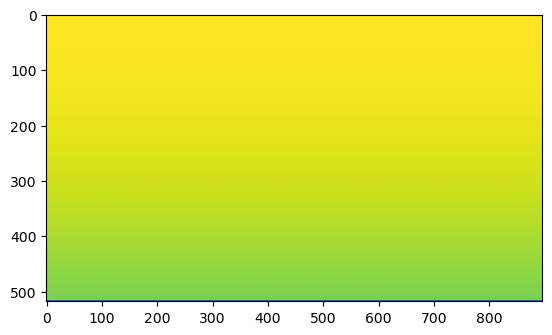

In [ ]:
plt.imshow(Re.pixel_surface)


(518, 896)
[0. 1.]


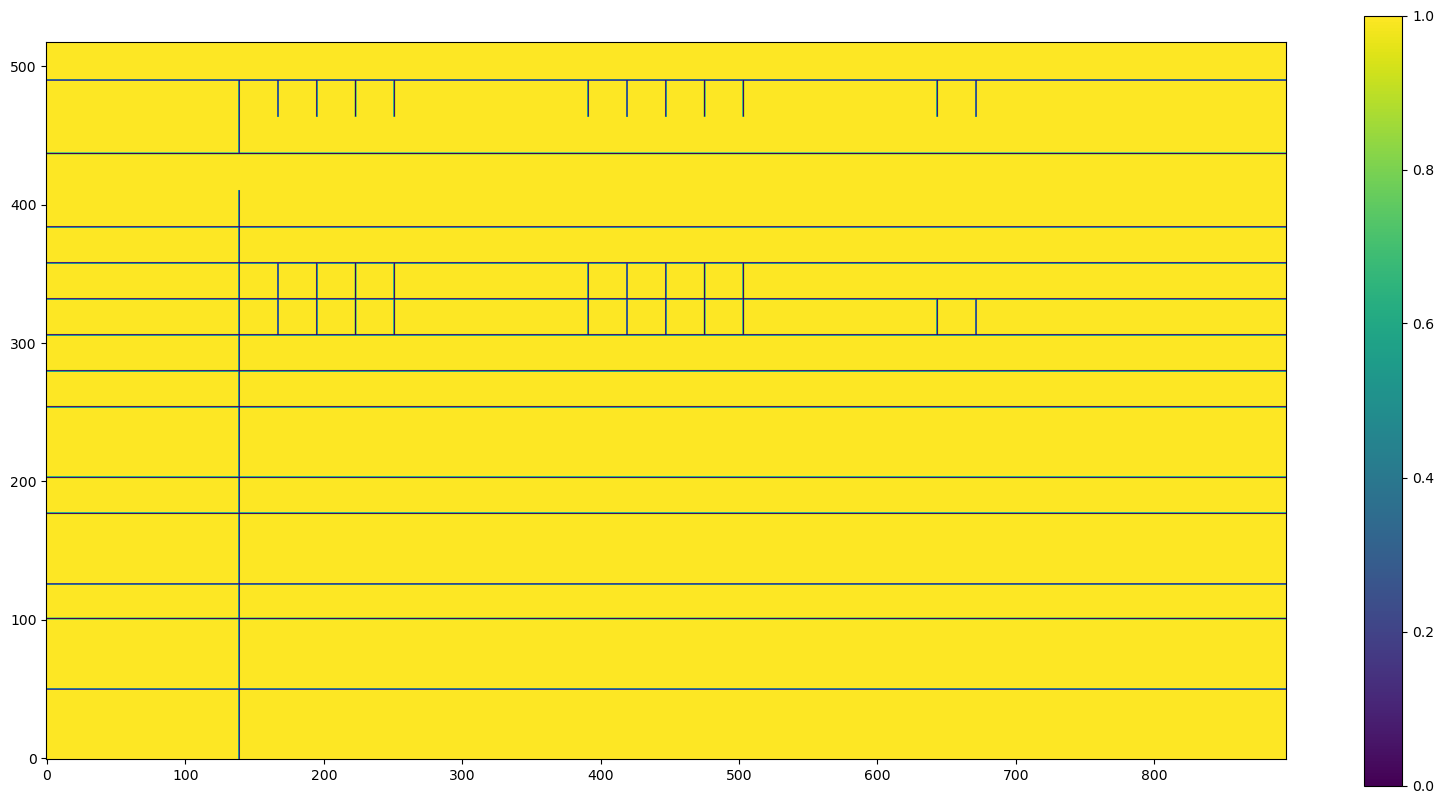

In [ ]:
x = Re.__build_alpha_max__()
Re.imshow(x)
print(np.unique(x))

(518, 895)


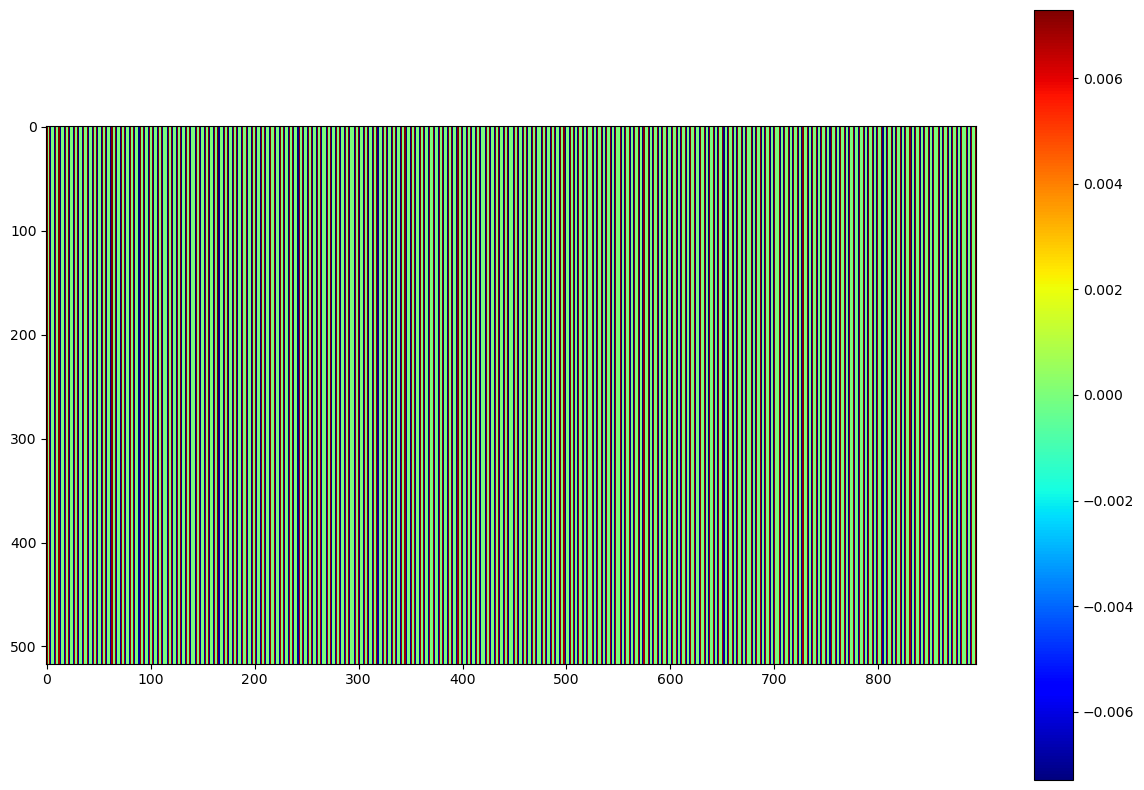

In [ ]:
## Plot pixel surface

fig = plt.figure(figsize = (15, 10))    
X = np.diff(Re.pixel_surface, axis = 1)

print(X.shape)
plt.imshow(X[0:517], cmap = 'jet', interpolation='nearest')
plt.colorbar()

In [ ]:
print("Goodbye world !")

Goodbye world !
